In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from collections import defaultdict

# Dataset class
class OmniglotDataset(Dataset):
    def __init__(self, transform, samples):       
        self.transform = transform        
        self.samples = samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):       
        img_path, alphabet, label = self.samples[idx]        
        img = Image.open(img_path).convert('L')       
        img = self.transform(img)
        
        return img, alphabet, label

# Neural Network
class Net(nn.Module):
    def __init__(self, num_alphabets=30, num_classes=964):
        super().__init__()       
        self.image_layer = nn.Sequential(           
            nn.Conv2d(1, 16, kernel_size=3, padding=1),          
            nn.MaxPool2d(kernel_size=2),          
            nn.ELU(),           
            nn.Flatten(),         
            nn.Linear(16*32*32, 128)       
        )        
        self.alphabet_layer = nn.Sequential(           
            nn.Linear(num_alphabets, 8),         
            nn.ELU(),     
        )       
        self.classifier = nn.Sequential(          
            nn.Linear(128 + 8, num_classes),       
        )
    
    def forward(self, x_image, x_alphabet):   
        x_image = self.image_layer(x_image)
        x_alphabet = self.alphabet_layer(x_alphabet)  
        x = torch.cat((x_image, x_alphabet), dim=1)
        return self.classifier(x)

# Data preparation function
def prepare_omniglot_data(data_dir='omniglot_train'):
    """
    Prepare Omniglot dataset samples and create mappings
    """
    samples = []
    alphabet_to_idx = {}
    char_to_idx = {}
    
    alphabet_idx = 0
    char_idx = 0
    
    # Walk through the dataset directory
    for alphabet in os.listdir(data_dir):
        alphabet_path = os.path.join(data_dir, alphabet)
        if not os.path.isdir(alphabet_path):
            continue
            
        if alphabet not in alphabet_to_idx:
            alphabet_to_idx[alphabet] = alphabet_idx
            alphabet_idx += 1
        
        for character in os.listdir(alphabet_path):
            char_path = os.path.join(alphabet_path, character)
            if not os.path.isdir(char_path):
                continue
                
            char_key = f"{alphabet}_{character}"
            if char_key not in char_to_idx:
                char_to_idx[char_key] = char_idx
                char_idx += 1
            
            # Add all images for this character
            for img_file in os.listdir(char_path):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(char_path, img_file)
                    samples.append((img_path, alphabet_to_idx[alphabet], char_to_idx[char_key]))
    
    return samples, alphabet_to_idx, char_to_idx

# Custom collate function to handle alphabet encoding
def custom_collate_fn(batch, num_alphabets):
    images, alphabets, labels = zip(*batch)
    
    # Stack images and labels
    images = torch.stack(images)
    labels = torch.tensor(labels, dtype=torch.long)
    
    # One-hot encode alphabets
    alphabet_tensor = torch.zeros(len(alphabets), num_alphabets)
    for i, alphabet_idx in enumerate(alphabets):
        alphabet_tensor[i, alphabet_idx] = 1.0
    
    return images, alphabet_tensor, labels

# Main training code
def main():
    # Prepare data
    print("Preparing Omniglot data...")
    samples, alphabet_to_idx, char_to_idx = prepare_omniglot_data('omniglot_train')
    
    num_alphabets = len(alphabet_to_idx)
    num_classes = len(char_to_idx)
    
    print(f"Found {len(samples)} samples across {num_alphabets} alphabets and {num_classes} characters")
    
    # Create dataset and dataloader
    dataset_train = OmniglotDataset(
        transform=transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ]),
        samples=samples,
    )
    
    # Custom collate function to handle alphabet encoding
    collate_fn = lambda batch: custom_collate_fn(batch, num_alphabets)
    
    dataloader_train = DataLoader(
        dataset_train, 
        shuffle=True, 
        batch_size=32,  # Increased batch size for better training
        collate_fn=collate_fn
    )
    
    # Initialize model, loss, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = Net(num_alphabets=num_alphabets, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam often works better than SGD
    
    # Training loop
    print("Starting training...")
    for epoch in range(10):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (img, alpha, labels) in enumerate(dataloader_train):        
            img, alpha, labels = img.to(device), alpha.to(device), labels.to(device)
            
            optimizer.zero_grad()      
            outputs = net(img, alpha)       
            loss = criterion(outputs, labels)       
            loss.backward()      
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 100 == 99:  # Print every 100 batches
                print(f'Epoch [{epoch+1}/10], Batch [{batch_idx+1}], '
                      f'Loss: {running_loss/100:.4f}, '
                      f'Accuracy: {100*correct/total:.2f}%')
                running_loss = 0.0
        
        # Epoch summary
        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/10] completed. Accuracy: {epoch_acc:.2f}%')
    
    print("Training completed!")
    
    # Save the model
    torch.save({
        'model_state_dict': net.state_dict(),
        'alphabet_to_idx': alphabet_to_idx,
        'char_to_idx': char_to_idx,
        'num_alphabets': num_alphabets,
        'num_classes': num_classes
    }, 'omniglot_model.pth')
    
    print("Model saved as 'omniglot_model.pth'")

if __name__ == "__main__":
    main()

Preparing Omniglot data...
Found 13251 samples across 29 alphabets and 915 characters
Starting training...
Epoch [1/10], Batch [100], Loss: 7.7721, Accuracy: 0.25%
Epoch [1/10], Batch [200], Loss: 6.6486, Accuracy: 0.47%
Epoch [1/10], Batch [300], Loss: 6.0682, Accuracy: 1.29%
Epoch [1/10], Batch [400], Loss: 5.3742, Accuracy: 2.48%
Epoch [1/10] completed. Accuracy: 2.78%
Epoch [2/10], Batch [100], Loss: 3.9702, Accuracy: 22.09%
Epoch [2/10], Batch [200], Loss: 3.6179, Accuracy: 24.47%
Epoch [2/10], Batch [300], Loss: 3.3054, Accuracy: 26.68%
Epoch [2/10], Batch [400], Loss: 3.0764, Accuracy: 28.89%
Epoch [2/10] completed. Accuracy: 29.21%
Epoch [3/10], Batch [100], Loss: 1.9440, Accuracy: 57.62%
Epoch [3/10], Batch [200], Loss: 1.9495, Accuracy: 56.30%
Epoch [3/10], Batch [300], Loss: 1.9893, Accuracy: 55.43%
Epoch [3/10], Batch [400], Loss: 1.9290, Accuracy: 55.30%
Epoch [3/10] completed. Accuracy: 55.38%
Epoch [4/10], Batch [100], Loss: 1.1315, Accuracy: 75.41%
Epoch [4/10], Batch [

Total samples: 13251
First sample: ('omniglot_train/Gujarati/character42/0459_14.png', 'Gujarati', 'character42')

First 5 samples:
Sample 1:
  Path: omniglot_train/Gujarati/character42/0459_14.png
  Alphabet: Gujarati
  Character: character42

Sample 2:
  Path: omniglot_train/Gujarati/character42/0459_16.png
  Alphabet: Gujarati
  Character: character42

Sample 3:
  Path: omniglot_train/Gujarati/character42/0459_02.png
  Alphabet: Gujarati
  Character: character42

Sample 4:
  Path: omniglot_train/Gujarati/character42/0459_06.png
  Alphabet: Gujarati
  Character: character42

Sample 5:
  Path: omniglot_train/Gujarati/character42/0459_07.png
  Alphabet: Gujarati
  Character: character42

Samples per alphabet:
  Alphabet_of_the_Magi: 301 samples
  Anglo-Saxon_Futhorc: 438 samples
  Arcadian: 398 samples
  Armenian: 620 samples
  Asomtavruli_(Georgian): 575 samples
  Balinese: 369 samples
  Blackfoot_(Canadian_Aboriginal_Syllabics): 205 samples
  Braille: 397 samples
  Burmese_(Myanmar):

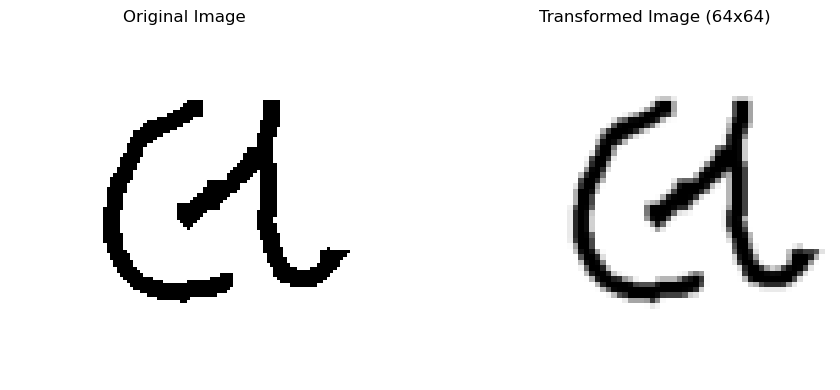


Visualizing first 3 samples:
Sample 0:
  Path: omniglot_train/Gujarati/character42/0459_14.png
  Alphabet: Gujarati
  Character: character42
  Original size: (105, 105)
  Transformed shape: torch.Size([1, 64, 64])


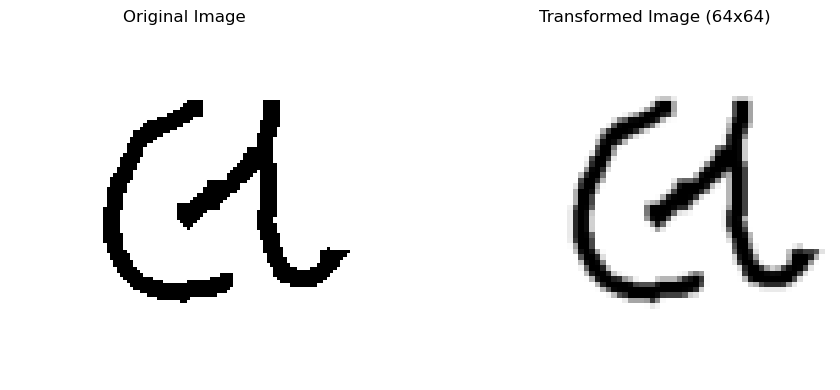

Sample 1:
  Path: omniglot_train/Gujarati/character42/0459_16.png
  Alphabet: Gujarati
  Character: character42
  Original size: (105, 105)
  Transformed shape: torch.Size([1, 64, 64])


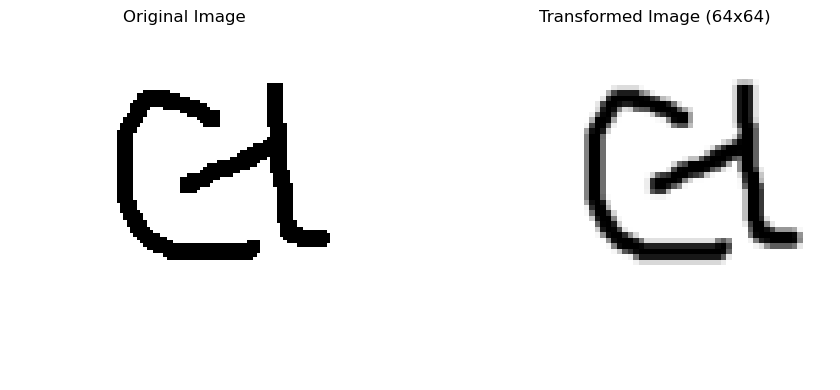

Sample 2:
  Path: omniglot_train/Gujarati/character42/0459_02.png
  Alphabet: Gujarati
  Character: character42
  Original size: (105, 105)
  Transformed shape: torch.Size([1, 64, 64])


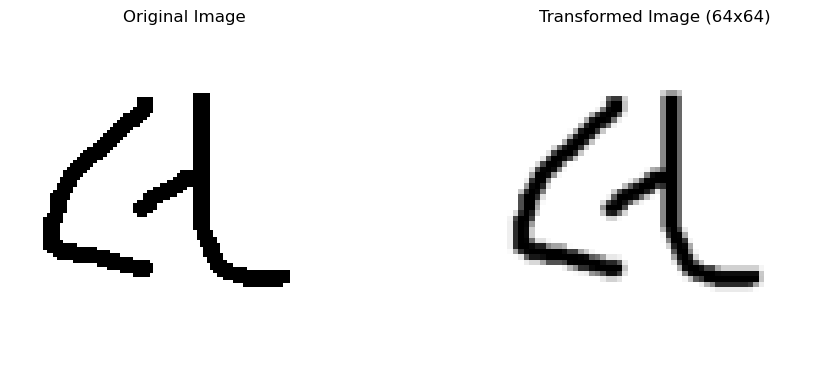

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

def load_omniglot_samples(data_dir):
    """
    Load samples from Omniglot dataset directory
    Returns list of tuples: (image_path, alphabet_name, character_name)
    """
    samples = []
    
    for alphabet in os.listdir(data_dir):
        alphabet_path = os.path.join(data_dir, alphabet)
        if not os.path.isdir(alphabet_path):
            continue
            
        for character in os.listdir(alphabet_path):
            char_path = os.path.join(alphabet_path, character)
            if not os.path.isdir(char_path):
                continue
            
            # Add all images for this character
            for img_file in os.listdir(char_path):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(char_path, img_file)
                    samples.append((img_path, alphabet, character))
    
    return samples

# Load the samples
samples = load_omniglot_samples('omniglot_train')

# Print basic information
print(f"Total samples: {len(samples)}")
print(f"First sample: {samples[0]}")
print()

# Print first few samples with more detail
print("First 5 samples:")
for i in range(min(5, len(samples))):
    img_path, alphabet, character = samples[i]
    print(f"Sample {i+1}:")
    print(f"  Path: {img_path}")
    print(f"  Alphabet: {alphabet}")
    print(f"  Character: {character}")
    print()

# Count samples per alphabet
from collections import defaultdict
alphabet_counts = defaultdict(int)
for _, alphabet, _ in samples:
    alphabet_counts[alphabet] += 1

print("Samples per alphabet:")
for alphabet, count in sorted(alphabet_counts.items()):
    print(f"  {alphabet}: {count} samples")

# Function to visualize a sample
def visualize_sample(sample_idx, samples, transform=None):
    """
    Visualize a specific sample from the dataset
    """
    if sample_idx >= len(samples):
        print(f"Sample index {sample_idx} is out of range. Max index: {len(samples)-1}")
        return
    
    img_path, alphabet, character = samples[sample_idx]
    
    # Load and display the image
    img = Image.open(img_path).convert('L')
    
    print(f"Sample {sample_idx}:")
    print(f"  Path: {img_path}")
    print(f"  Alphabet: {alphabet}")
    print(f"  Character: {character}")
    print(f"  Original size: {img.size}")
    
    # Apply transform if provided
    if transform:
        img_transformed = transform(img)
        print(f"  Transformed shape: {img_transformed.shape}")
        
        # Convert tensor back to PIL for visualization
        if hasattr(img_transformed, 'numpy'):
            img_transformed = img_transformed.squeeze().numpy()
        
        # Create subplot to show original and transformed
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(img_transformed, cmap='gray')
        axes[1].set_title('Transformed Image (64x64)')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(5, 5))
        plt.imshow(img, cmap='gray')
        plt.title(f'Alphabet: {alphabet}, Character: {character}')
        plt.axis('off')
        plt.show()

# Assign samples and transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Check the first sample
print("\n" + "="*50)
print("DETAILED SAMPLE INSPECTION")
print("="*50)
print(samples[0])

# Visualize the first sample
print("\nVisualizing first sample:")
visualize_sample(0, samples, transform)

# You can also inspect multiple samples
print("\nVisualizing first 3 samples:")
for i in range(min(3, len(samples))):
    visualize_sample(i, samples, transform)

## Two-Output Architecture 

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from collections import defaultdict

class OmniglotDataset(Dataset):
    def __init__(self, transform, samples, alphabet_to_idx, char_to_idx):      
        self.transform = transform       
        self.samples = samples
        self.alphabet_to_idx = alphabet_to_idx
        self.char_to_idx = char_to_idx
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):        
        img_path, alphabet_name, char_name = self.samples[idx]
        
        # Load and transform image
        img = Image.open(img_path).convert('L')       
        img = self.transform(img)
        
        # Convert names to indices
        alphabet_idx = self.alphabet_to_idx[alphabet_name]
        char_key = f"{alphabet_name}_{char_name}"
        char_idx = self.char_to_idx[char_key]
        
        return img, alphabet_idx, char_idx

class TwoOutputNet(nn.Module):
    def __init__(self, num_alphabets, num_characters, hidden_dim=256):
        super().__init__()        
        
        # Shared feature extractor
        self.feature_extractor = nn.Sequential(           
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.AdaptiveAvgPool2d((4, 4)),  # Ensures consistent output size
            nn.Flatten(),
        )
        
        # Calculate the flattened feature size
        feature_size = 128 * 4 * 4  # 128 channels * 4 * 4 spatial dimensions
        
        # Shared hidden layer
        self.shared_hidden = nn.Sequential(
            nn.Linear(feature_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Task-specific heads
        self.alphabet_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_alphabets)
        )
        
        self.character_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_characters)
        )
    
    def forward(self, x):       
        # Extract features
        features = self.feature_extractor(x)
        shared_features = self.shared_hidden(features)
        
        # Task-specific predictions
        alphabet_output = self.alphabet_classifier(shared_features)       
        character_output = self.character_classifier(shared_features)
        
        return alphabet_output, character_output

def load_omniglot_samples_with_mappings(data_dir):
    """
    Load samples and create mappings for alphabets and characters
    """
    samples = []
    alphabet_to_idx = {}
    char_to_idx = {}
    
    alphabet_idx = 0
    char_idx = 0
    
    for alphabet in sorted(os.listdir(data_dir)):
        alphabet_path = os.path.join(data_dir, alphabet)
        if not os.path.isdir(alphabet_path):
            continue
            
        if alphabet not in alphabet_to_idx:
            alphabet_to_idx[alphabet] = alphabet_idx
            alphabet_idx += 1
        
        for character in sorted(os.listdir(alphabet_path)):
            char_path = os.path.join(alphabet_path, character)
            if not os.path.isdir(char_path):
                continue
                
            char_key = f"{alphabet}_{character}"
            if char_key not in char_to_idx:
                char_to_idx[char_key] = char_idx
                char_idx += 1
            
            # Add all images for this character
            for img_file in sorted(os.listdir(char_path)):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(char_path, img_file)
                    samples.append((img_path, alphabet, character))
    
    return samples, alphabet_to_idx, char_to_idx

def calculate_accuracy(outputs, labels):
    """Calculate accuracy for a batch"""
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def train_two_output_model():
    # Data preparation
    print("Loading Omniglot dataset...")
    samples, alphabet_to_idx, char_to_idx = load_omniglot_samples_with_mappings('omniglot_train')
    
    num_alphabets = len(alphabet_to_idx)
    num_characters = len(char_to_idx)
    
    print(f"Found {len(samples)} samples")
    print(f"Number of alphabets: {num_alphabets}")
    print(f"Number of characters: {num_characters}")
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomRotation(15),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    # Create dataset and dataloader
    dataset = OmniglotDataset(
        transform=transform,
        samples=samples,
        alphabet_to_idx=alphabet_to_idx,
        char_to_idx=char_to_idx
    )
    
    dataloader = DataLoader(
        dataset, 
        batch_size=64, 
        shuffle=True,
        num_workers=2 if torch.cuda.is_available() else 0
    )
    
    # Model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = TwoOutputNet(
        num_alphabets=num_alphabets,
        num_characters=num_characters,
        hidden_dim=512
    ).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    # Training loop
    print("\nStarting training...")
    model.train()
    
    for epoch in range(15):  # Increased epochs for better convergence
        running_loss = 0.0
        running_loss_alpha = 0.0
        running_loss_char = 0.0
        running_acc_alpha = 0.0
        running_acc_char = 0.0
        num_batches = 0
        
        for batch_idx, (images, labels_alpha, labels_char) in enumerate(dataloader):
            # Move to device
            images = images.to(device)
            labels_alpha = labels_alpha.to(device)
            labels_char = labels_char.to(device)
            
            # Forward pass
            optimizer.zero_grad()        
            outputs_alpha, outputs_char = model(images)
            
            # Calculate losses
            loss_alpha = criterion(outputs_alpha, labels_alpha)       
            loss_char = criterion(outputs_char, labels_char)
            
            # Weighted combination (you can adjust these weights)
            alpha_weight = 0.3
            char_weight = 0.7
            total_loss = alpha_weight * loss_alpha + char_weight * loss_char
            
            # Backward pass
            total_loss.backward()      
            optimizer.step()
            
            # Calculate accuracies
            acc_alpha = calculate_accuracy(outputs_alpha, labels_alpha)
            acc_char = calculate_accuracy(outputs_char, labels_char)
            
            # Update running statistics
            running_loss += total_loss.item()
            running_loss_alpha += loss_alpha.item()
            running_loss_char += loss_char.item()
            running_acc_alpha += acc_alpha
            running_acc_char += acc_char
            num_batches += 1
            
            # Print progress every 100 batches
            if (batch_idx + 1) % 100 == 0:
                avg_loss = running_loss / num_batches
                avg_loss_alpha = running_loss_alpha / num_batches
                avg_loss_char = running_loss_char / num_batches
                avg_acc_alpha = running_acc_alpha / num_batches
                avg_acc_char = running_acc_char / num_batches
                
                print(f'Epoch [{epoch+1}/15], Batch [{batch_idx+1}]')
                print(f'  Total Loss: {avg_loss:.4f}')
                print(f'  Alpha Loss: {avg_loss_alpha:.4f}, Acc: {avg_acc_alpha:.3f}')
                print(f'  Char Loss: {avg_loss_char:.4f}, Acc: {avg_acc_char:.3f}')
        
        # End of epoch statistics
        scheduler.step()
        
        avg_loss = running_loss / num_batches
        avg_acc_alpha = running_acc_alpha / num_batches
        avg_acc_char = running_acc_char / num_batches
        
        print(f'\nEpoch [{epoch+1}/15] Summary:')
        print(f'  Average Loss: {avg_loss:.4f}')
        print(f'  Alphabet Accuracy: {avg_acc_alpha:.3f}')
        print(f'  Character Accuracy: {avg_acc_char:.3f}')
        print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 50)
    
    print("Training completed!")
    
    # Save the model
    torch.save({
        'model_state_dict': model.state_dict(),
        'alphabet_to_idx': alphabet_to_idx,
        'char_to_idx': char_to_idx,
        'num_alphabets': num_alphabets,
        'num_characters': num_characters,
    }, 'two_output_omniglot_model.pth')
    
    print("Model saved as 'two_output_omniglot_model.pth'")
    
    return model, alphabet_to_idx, char_to_idx

def evaluate_model(model, dataloader, device):
    """Evaluate the model on a dataset"""
    model.eval()
    total_alpha_correct = 0
    total_char_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels_alpha, labels_char in dataloader:
            images = images.to(device)
            labels_alpha = labels_alpha.to(device)
            labels_char = labels_char.to(device)
            
            outputs_alpha, outputs_char = model(images)
            
            # Calculate accuracies
            _, pred_alpha = torch.max(outputs_alpha, 1)
            _, pred_char = torch.max(outputs_char, 1)
            
            total_alpha_correct += (pred_alpha == labels_alpha).sum().item()
            total_char_correct += (pred_char == labels_char).sum().item()
            total_samples += labels_alpha.size(0)
    
    alpha_acc = total_alpha_correct / total_samples
    char_acc = total_char_correct / total_samples
    
    return alpha_acc, char_acc

# Example usage
if __name__ == "__main__":
    model, alphabet_to_idx, char_to_idx = train_two_output_model()

Loading Omniglot dataset...
Found 13251 samples
Number of alphabets: 29
Number of characters: 915
Using device: cpu

Starting training...
Epoch [1/15], Batch [100]
  Total Loss: 5.7508
  Alpha Loss: 3.2194, Acc: 0.098
  Char Loss: 6.8357, Acc: 0.002
Epoch [1/15], Batch [200]
  Total Loss: 5.6048
  Alpha Loss: 3.0636, Acc: 0.123
  Char Loss: 6.6938, Acc: 0.002

Epoch [1/15] Summary:
  Average Loss: 5.5914
  Alphabet Accuracy: 0.125
  Character Accuracy: 0.002
  Learning Rate: 0.001000
--------------------------------------------------
Epoch [2/15], Batch [100]
  Total Loss: 5.0717
  Alpha Loss: 2.7895, Acc: 0.179
  Char Loss: 6.0498, Acc: 0.008
Epoch [2/15], Batch [200]
  Total Loss: 4.9829
  Alpha Loss: 2.7384, Acc: 0.192
  Char Loss: 5.9448, Acc: 0.010

Epoch [2/15] Summary:
  Average Loss: 4.9756
  Alphabet Accuracy: 0.193
  Character Accuracy: 0.010
  Learning Rate: 0.001000
--------------------------------------------------
Epoch [3/15], Batch [100]
  Total Loss: 4.6601
  Alpha Los